In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
df_photo = pd.read_csv('./data/stripe82candidateVar_v1.1.dat',skiprows=5, header=1,index_col=0,sep='\s+')

In [3]:
#df_photo.head()

In [4]:
colnames = ['ID','Priority','Flags','Teff','eTeff','NTeff','logg','elogg','Nlogg','Z','eZ','NZ']
df_spec = pd.read_csv('./data/t3.txt',sep='\s+',skiprows=26,header=None,index_col=0,names=colnames)

In [5]:
#Combine both datasets 
df = pd.merge(df_spec, df_photo, on='ID',how='left')

In [6]:
df.head()

,Priority,Flags,Teff,eTeff,NTeff,logg,elogg,Nlogg,Z,eZ,...,ri,iz,gN,gAmpl,rN,rAmpl,iN,iAmpl,zQSO,MiQSO
ID,,,,,,,,,,,,,,,,,,,,,
4172970,4.0,nnnnn,5499.7,94.7,7,3.94,0.18,6,0.01,0.12,...,0.13,0.07,29,0.197,27,0.156,27,0.231,-9.9,-9.9
4583821,5.0,Nnnnn,4487.8,120.3,3,4.19,0.26,2,-0.95,0.08,...,0.30,0.16,50,0.124,49,0.106,51,0.094,-9.9,-9.9
4651452,2.0,NnBnX,-9999.0,-9999.0,0,-9999.00,-9999.00,0,-9999.00,-9999.00,...,-0.06,0.26,36,0.505,33,0.460,27,1.150,-9.9,-9.9
4777216,9.0,nnnnX,-9999.0,-9999.0,0,-9999.00,-9999.00,0,-9999.00,-9999.00,...,0.10,0.02,47,0.133,47,0.394,47,0.154,-9.9,-9.9
5302673,9.0,nnnnn,5986.7,161.8,4,3.93,0.79,2,-0.76,0.09,...,0.13,-0.05,36,0.332,33,0.175,39,0.253,-9.9,-9.9


In [7]:
df.columns

Index(['Priority', 'Flags', 'Teff', 'eTeff', 'NTeff', 'logg', 'elogg', 'Nlogg',
       'Z', 'eZ', 'NZ', 'ra', 'dec', 'P', 'r', 'ug', 'gr', 'ri', 'iz', 'gN',
       'gAmpl', 'rN', 'rAmpl', 'iN', 'iAmpl', 'zQSO', 'MiQSO'],
      dtype='object')

In [8]:
# Cleaning the training set not clearly mentioned in the paper. 
#Usign the entire dataset for now
#df = df[(df['Flags'] != 'nnnnn') & (df[Z] > -3.0)]

# Neural Network

In [9]:
df_nonan = df[df['Teff'] != -9999.0]

In [25]:
len(df_nonan)

3960

In [10]:
df_Y = df_nonan['Teff']

In [11]:
#Using just photometry and no light curve information
df_X = df_nonan[['ug','gr','ri','iz']]

In [27]:
train_X, test_X, train_y, test_y = train_test_split(df_X, df_Y, random_state=1, test_size=0.25)

In [28]:
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ug,2970.0,1.607599,0.507682,-0.05,1.19,1.48,1.97,3.19
gr,2970.0,0.605354,0.282562,-0.23,0.41,0.54,0.77,1.41
ri,2970.0,0.213303,0.137128,-0.27,0.13,0.18,0.27,1.22
iz,2970.0,0.080121,0.098160,-0.29,0.01,0.06,0.13,0.71


In [14]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_X)
# normed_test_data = norm(test_X)

In [31]:
test_y.describe()

count     990.000000
mean     5416.829394
std       671.423738
min      4006.200000
25%      4936.400000
50%      5465.550000
75%      5822.925000
max      8146.200000
Name: Teff, dtype: float64

In [18]:
"""
model_temp = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_X.columns),)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
"""

model_temp = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_X.columns),)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

In [19]:
adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [53]:
model_temp.compile(optimizer='adam',
              loss='mape',
              metrics=['mae', 'mse','msle','mape','kullback_leibler_divergence'])

In [54]:
example_batch = normed_train_data[:10]
example_result = model_temp.predict(example_batch)
example_result

array([[5971.429 ],
       [5781.317 ],
       [4575.649 ],
       [5261.316 ],
       [5614.35  ],
       [4535.476 ],
       [5694.139 ],
       [4304.102 ],
       [5880.6772],
       [5797.6733]], dtype=float32)

In [55]:
history = model_temp.fit(normed_train_data, train_y, epochs=1000, batch_size=32, validation_split = 0.15)

Train on 2524 samples, validate on 446 samples
Epoch 1/1000
2524/2524 [==============================] - 1s 220us/sample - loss: 1.7719 - mae: 96.9963 - mse: 20148.9395 - msle: 6.1305e-04 - mape: 1.7719 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.8580 - val_mae: 101.1771 - val_mse: 23444.7246 - val_msle: 8.2575e-04 - val_mape: 1.8580 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 2/1000
2524/2524 [==============================] - 0s 43us/sample - loss: 1.7707 - mae: 96.9516 - mse: 20255.5664 - msle: 6.1691e-04 - mape: 1.7707 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.8777 - val_mae: 101.9439 - val_mse: 22856.6914 - val_msle: 8.0508e-04 - val_mape: 1.8777 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 3/1000
2524/2524 [==============================] - 0s 41us/sample - loss: 1.7791 - mae: 97.3127 - mse: 20239.4688 - msle: 6.1637e-04 - mape: 1.7791 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.8632 - val_mae: 101.1343 - val_mse: 23042.3203 - 

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,msle,mape,kullback_leibler_divergence,val_loss,val_mae,val_mse,val_msle,val_mape,val_kullback_leibler_divergence,epoch
995,1.737461,94.988106,18853.642578,0.000580,1.737462,0.0,1.886529,102.306084,23083.115234,0.000810,1.886529,0.0,995
996,1.746871,95.415924,19047.466797,0.000588,1.746871,0.0,1.883495,102.676254,23240.142578,0.000812,1.883495,0.0,996
997,1.738986,95.112724,18919.623047,0.000583,1.738986,0.0,1.848881,100.799118,23194.560547,0.000812,1.848881,0.0,997
998,1.738921,95.108574,19092.511719,0.000587,1.738921,0.0,1.894427,103.099739,23255.039062,0.000813,1.894427,0.0,998
999,1.738690,95.039459,18928.958984,0.000583,1.738689,0.0,1.895991,102.672989,23020.630859,0.000809,1.895990,0.0,999


In [41]:
loss, mae, mse = model_temp.evaluate(normed_test_data, test_y)

990/990 [==============================] - 0s 27us/sample - loss: 1.8982 - mse: 21603.0156 - mape: 1.8982


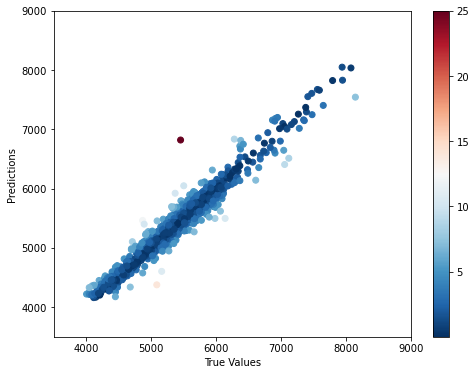

In [61]:
test_predictions = model_temp.predict(normed_test_data).flatten()
t_y = test_y.to_numpy()
error = 100*abs(t_y-test_predictions)/t_y

fig = plt.figure(1,figsize=(8,6))
plt.scatter(test_y, test_predictions,c=error,cmap='RdBu_r')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim(3500,9000)
plt.ylim(3500,9000)
plt.colorbar()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)